<a href="https://colab.research.google.com/github/kavanshah1197/Machine_Learning/blob/trying_feature/Trial_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
PV_data = pd.read_csv('/content/drive/My Drive/MS Thesis/Thick_walled_PV/PV_data.csv', header = None).to_numpy()

In [ ]:
X = PV_data[0:4, :]
num_data_points = X.shape[1]
Y = PV_data[4, :].reshape(1, num_data_points)

shuffled_cols = np.random.permutation(num_data_points)

percent_training = 80/100
percent_dev = 15/100
percent_test = 5/100

m_train = math.floor(percent_training*num_data_points)
m_dev = math.floor(percent_dev*num_data_points)
m_test = num_data_points - m_train - m_dev

X_train = X[:, shuffled_cols[0:m_train]]
X_dev = X[:, shuffled_cols[m_train: m_train + m_dev]]
X_test = X[:, shuffled_cols[m_train + m_dev: ]]

Y_train = Y[:, shuffled_cols[0:m_train]]
Y_dev = Y[:, shuffled_cols[m_train: m_train + m_dev]]
Y_test = Y[:, shuffled_cols[m_train + m_dev: ]]

X_train_mean = np.mean(X_train, axis = 1, keepdims=True)
X_train_std = np.std(X_train, axis = 1, keepdims=True)

X_train_n = (X_train-X_train_mean)/X_train_std
X_dev_n = (X_dev - X_train_mean)/X_train_std
X_test_n = (X_test - X_train_mean)/X_train_std
abc = 1


In [ ]:
num_hidden_layers = 2
num_layers = num_hidden_layers + 1

n_x = X_train_n.shape[0]
n_h1 = 8
n_h2 = 8
n_y = Y_train.shape[0]
num_units_list = [n_x, n_h1, n_h2, n_y]

act_h1 = 'relu'
act_h2 = 'relu'
act_L = 'relu'
act_fun_list = [act_h1, act_h2, act_L]

lambd = 0

learning_rate = 1e-4
num_iters = 90000

In [ ]:
def initialize_params(n_input, n_output, act_fun = 'relu'):

  if act_fun == 'sigmoid' or act_fun == 'tanh':
    W = np.random.randn(n_output, n_input)*0.01#*np.sqrt(1/n_input)
  elif act_fun == 'relu' or act_fun == 'leaky_relu':
    W = np.random.randn(n_output, n_input)*0.01#*np.sqrt(2/n_input)
  else:
    W = np.random.randn(n_output, n_input)*0.01

  b = np.zeros((n_output, 1))

  return W, b

In [ ]:
def initialize_params_nn(num_units_list, act_fun_list):
  np.random.seed(3)
  num_layers = len(act_fun_list)
  parameters = {}
  for l in range(num_layers):
    parameters['W' + str(l+1)], parameters['b' + str(l+1)] = initialize_params(num_units_list[l], num_units_list[l+1], act_fun_list[l])

  return parameters

In [ ]:
def activ(z, act_fun = 'relu'):

  if act_fun == 'relu':
    a = np.maximum(0, z)
  elif act_fun == 'leaky_relu':
    a = np.maximum(0.01*z, z)
  elif act_fun == 'sigmoid':
    a = 1/(1+np.exp(-z))
  elif act_fun == 'tanh':
    a = (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
  elif act_fun == 'linear':
    a = z

  return a

In [ ]:
def forward_prop_nn(X, parameters, act_fun_list):

  num_layers = len(act_fun_list)
  cache = {}
  current_layer_data = X
  for l in range(num_layers):
    cache['z' + str(l+1)] = np.dot(parameters['W' + str(l+1)], current_layer_data) + parameters['b' + str(l+1)]
    cache['a' + str(l+1)] = activ(cache['z' + str(l+1)], act_fun = act_fun_list[l])
    current_layer_data = cache['a' + str(l+1)]

  AL = cache['a' + str(num_layers)]
  cache['a0'] = X
  return cache, AL

In [ ]:
def cost_func(AL, Y):

  m = Y.shape[1]
  cost = np.sqrt(np.sum(np.square(AL - Y))/m)
  #cost = (-1/m)*np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
  cost = np.squeeze(cost)
  return cost

In [ ]:
def act_fun_deriv(z, act_fun):

  if act_fun == 'relu':
    act_fun_grad = (z>=0).astype(int)
  elif act_fun == 'sigmoid':
    act_fun_grad = activ(z, 'sigmoid')*(1-activ(z, 'sigmoid'))
  elif act_fun == 'linear':
    act_fun_grad = np.ones(z.shape)

  return act_fun_grad

In [ ]:
def backprop_nn(AL, Y, act_fun_list, cache, parameters, cost):

  num_layers = len(act_fun_list)
  m = Y.shape[1]
  grads = {}

  dA3 = (1/(m*cost))*(AL - Y)
  dZ3 = dA3*act_fun_deriv(cache['z3'], 'relu')
  grads['dW3'] = np.dot(dZ3, cache['a2'].T)
  grads['db3'] = np.sum(dZ3, axis=1, keepdims=True)

  dA2 = np.dot(parameters['W3'].T, dZ3)
  dZ2 = dA2*act_fun_deriv(cache['z2'], 'relu')
  grads['dW2'] = np.dot(dZ2, cache['a1'].T)
  grads['db2'] = np.sum(dZ2, axis=1, keepdims=True)

  dA1 = np.dot(parameters['W2'].T, dZ2)
  dZ1 = dA1*act_fun_deriv(cache['z1'], 'relu')
  grads['dW1'] = np.dot(dZ1, cache['a0'].T)
  grads['db1'] = np.sum(dZ1, axis=1, keepdims=True)

  return grads

In [ ]:
def update_params(parameters, grads, learning_rate, num_layers):

  for l in range(num_layers):
    parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
    parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

  return parameters

In [ ]:
parameters = initialize_params_nn(num_units_list, act_fun_list)
cost_tracker = np.zeros(num_iters)
for iter in range(num_iters):
  cache, AL = forward_prop_nn(X_train_n, parameters, act_fun_list)
  cost_tracker[iter] = cost_func(AL, Y_train)
  grads = backprop_nn(AL, Y_train, act_fun_list, cache, parameters, cost_tracker[iter])
  parameters = update_params(parameters, grads, learning_rate, num_layers)

In [ ]:
cost_tracker

array([38036130.90498734, 38036130.90494516, 38036130.90485875, ...,
        1444943.12302086,  2259938.01836547,  1444911.10802743])

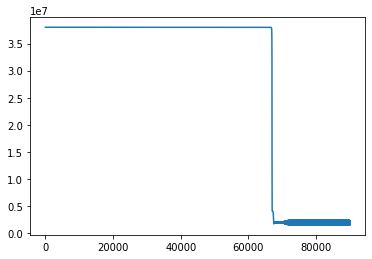

In [ ]:
plt.plot(np.arange(num_iters), cost_tracker)

In [ ]:
AL

array([[46095605.62788823, 34043671.52564763, 39327353.38332728, ...,
        22826386.96510576, 40510782.5437315 , 38208595.4588739 ]])

In [ ]:
Y_train

array([[44215925.49999998, 32468662.50565584, 37854010.58208311, ...,
        21368156.33066665, 39181568.99834494, 36375667.73833975]])

In [ ]:
cost_tracker[-1]

1444911.108027432

In [ ]:
np.mean(AL - Y_train)

1212247.3902373035